In [ ]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

from src.training import Trainer_vec
from src.vector_object import Frame_vec
from tqdm.notebook import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

======================== model built ========================
torch.Size([4, 300, 3]) torch.Size([4, 300, 2])


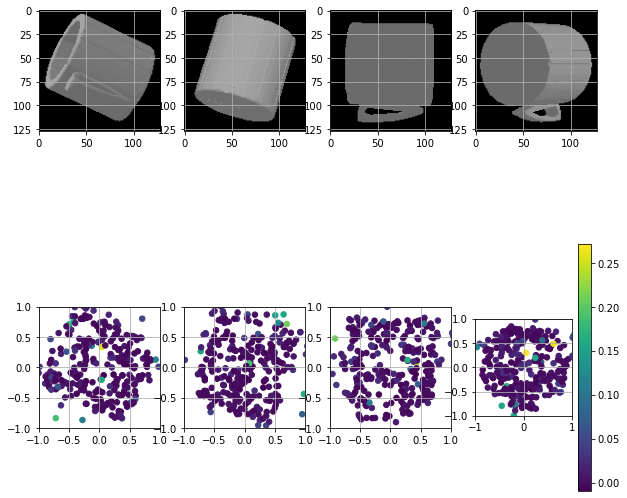

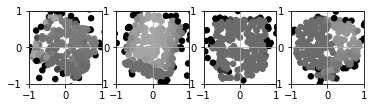

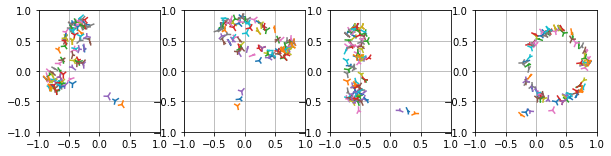

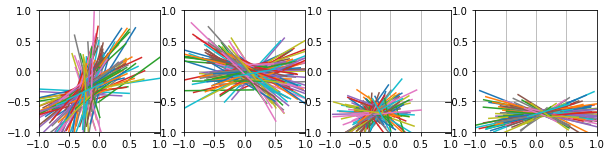

In [2]:
dx = torch.linspace(-1., 1., 3)
grid_x, grid_y, grid_z = torch.meshgrid(dx, dx, dx)
gripper_grid_pts = torch.stack([0.05*grid_x.flatten(),
                                0.02*grid_y.flatten(),
                                0.05*grid_z.flatten()], dim=1)

hook_grid_pts = torch.stack([torch.zeros(5),
                             torch.zeros(5),
                             torch.linspace(-0.1, 0.1, 5)], dim=1)

C = {
    'SEED': 1,
    
    'DATA_FILENAME': 'data/train_batch.hdf5',
    'TEST_DATA_FILENAME': 'data/val_batch.hdf5',
    'DATA_ON_GPU': device=="cuda",
    
    'SDF_HEAD_HIDDEN': [128],
    'NUM_POINTS': 300,
    'SDF_SCALE': 10.,
    
    'GRASP_LOSS_WEIGHT': 1.,
    'GRASP_HEAD_HIDDEN': [256, 128],
    'GRIPPER_POINTS': gripper_grid_pts,
    'NUM_GRASPS': 100,
    'GRASP_COST_SCALE': torch.Tensor([10,10,10,1,1,1]),
    'GRASP_DRAW_POINTS': 0.01*torch.eye(3),
    
    'HANG_LOSS_WEIGHT': 1.,
    'HANG_HEAD_HIDDEN': [256, 128],
    'HOOK_POINTS': hook_grid_pts,
    'NUM_HANGS': 100,
    'HANG_COST_SCALE': torch.Tensor([10,10,10,1,1,0]),
    'HANG_DRAW_POINTS': 0.1*torch.Tensor([[0,0,1],[0,0,-1]]),
    
    'TEST_INTERVAL': 10,
    'SAVE_INTERVAL': 100,
    
    'EXP_NAME': 'vectorObject',
}

torch.manual_seed(C['SEED'])

# Model
obj = Frame_vec()
obj.build_backbone(**C)
obj.build_sdf_head(C['SDF_HEAD_HIDDEN'])
obj.build_pose_head('grasp', C['GRASP_HEAD_HIDDEN'])
obj.build_pose_head('hang', C['HANG_HEAD_HIDDEN'])
obj.to(device).train()
print('======================== model built ========================')

trainer = Trainer_vec(obj, C)
trainer.trainset.show_data(0)
min_test = 100000

In [ ]:
for epoch in tqdm(range(1,trainer.C['NUM_EPOCHS']+1)):
    trainer.train(epoch)
    if epoch % C['TEST_INTERVAL'] == 0:
        test_loss = trainer.test(epoch)
        if test_loss < min_test and epoch % C['SAVE_INTERVAL'] == 0:
            trainer.save_state('network/'+C['EXP_NAME']+'_best.pth.tar')
            min_test = test_loss
    if epoch % C['SAVE_INTERVAL'] == 0:
        trainer.save_state('network/'+C['EXP_NAME']+'.pth.tar')

  0%|          | 0/1000000 [00:00<?, ?it/s]